Actuarial Control Cycle:
 - Environment
 - Specify the problem
 - Develop a solution
 - Monitoring and Feedback

Objectives:
 - find a momentum strategy to trade accross all linear-perpetual contracts.
 - verify the backtests (this is important to guard against spurious results e.g. from look-ahead bias.)
 - also need to do a walk forward optimization.
 - explore trade filters based on ML.

In [46]:
# SETTINGS
import os
import sys

# get the current working directory
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

# change the working directory to the project directory
proj_directory = r'C:\users\paul208\Repos\quant-trading-suite'

# add root directory of project to the sys.path
sys.path.append('C:\\users\\paul208\\Repos\\quant-trading-suite')

try:
    os.chdir(proj_directory)
    print(f"Changed to: {proj_directory}")
except FileNotFoundError:
    print(f"Directory not found: {proj_directory}")

    
#os.listdir()

Current Working Directory: C:\users\paul208\Repos\quant-trading-suite
Changed to: C:\users\paul208\Repos\quant-trading-suite


In [47]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
from datetime import timedelta
from pylab import mpl, plt
import seaborn as sns
from scripts.data_download import get_bybit_data, get_bybit_asset_info
from scipy.optimize import brute

In [48]:
# List All Symbols
pd.options.display.max_rows = 340
df_info = get_bybit_asset_info()
df_info.sort_values('Launch_Time',ascending=False)

,Symbol,Product_Type,Status,Base_Asset,Quote_Asset,Launch_Time,Delivery_Time,Min_Price,Max_Price,Tick_Size,Max_Qty,Min_Qty,Qty_Step,Delivery_time
71,BTC-22MAR24,LinearFutures,Trading,BTC,USDC,2024-03-01 08:00:00,1711094400000,0.50,999999.00,0.50,10.000,0.001,0.001,2024-03-22 08:00:00
120,ETH-22MAR24,LinearFutures,Trading,ETH,USDC,2024-03-01 08:00:00,1711094400000,0.05,99999.90,0.05,150.00,0.01,0.01,2024-03-22 08:00:00
241,PORTALUSDT,LinearPerpetual,Trading,PORTAL,USDT,2024-03-01 03:40:58,0,0.0001,199.9998,0.0001,30000.0,0.1,0.1,1970-01-01 00:00:00
11,1000TURBOUSDT,LinearPerpetual,Trading,1000TURBO,USDT,2024-02-29 11:12:19,0,0.0001,199.9998,0.0001,75000,1,1,1970-01-01 00:00:00
70,BTC-15MAR24,LinearFutures,Trading,BTC,USDC,2024-02-23 08:00:00,1710489600000,0.50,999999.00,0.50,10.000,0.001,0.001,2024-03-15 08:00:00
119,ETH-15MAR24,LinearFutures,Trading,ETH,USDC,2024-02-23 08:00:00,1710489600000,0.05,99999.90,0.05,150.00,0.01,0.01,2024-03-15 08:00:00
209,MOBILEUSDT,LinearPerpetual,Trading,MOBILE,USDT,2024-02-22 10:39:21,0,0.000001,1.999998,0.000001,12500000,100,100,1970-01-01 00:00:00
285,STRKUSDT,LinearPerpetual,Trading,STRK,USDT,2024-02-20 13:42:06,0,0.001,1999.998,0.001,162495.0,0.1,0.1,1970-01-01 00:00:00
239,PIXELUSDT,LinearPerpetual,Trading,PIXEL,USDT,2024-02-20 08:06:10,0,0.0001,199.9998,0.0001,221788,1,1,1970-01-01 00:00:00
257,RONUSDT,LinearPerpetual,Trading,RON,USDT,2024-02-20 07:48:18,0,0.001,1999.998,0.001,26230.0,0.1,0.1,1970-01-01 00:00:00


In [49]:
# IMPORT DATA
# Download data (1 hour interval data)
SYMBOL = 'SUPERUSDT'
INTERVAL = 60
START_TIME = '2020-01-01 00:00:00'

raw_data = get_bybit_data(product_type='linear', symbol=SYMBOL, interval=INTERVAL,
                      start_time=START_TIME,
                      verbose=False)

raw_data

,Time,Open,High,Low,Close,Volume
0,2023-11-23 10:00:00,0.2099,0.2236,0.2089,0.2208,2405126
1,2023-11-23 11:00:00,0.2208,0.2232,0.2124,0.2132,5277414
2,2023-11-23 12:00:00,0.2132,0.2147,0.2062,0.2108,5179604
3,2023-11-23 13:00:00,0.2108,0.2158,0.2084,0.2094,3442029
4,2023-11-23 14:00:00,0.2094,0.2126,0.2083,0.2089,1391952
...,...,...,...,...,...,...
2407,2024-03-02 17:00:00,1.4250,1.4533,1.4238,1.4461,364992
2408,2024-03-02 18:00:00,1.4461,1.4928,1.4450,1.4867,599482
2409,2024-03-02 19:00:00,1.4867,1.4995,1.4671,1.4963,520270
2410,2024-03-02 20:00:00,1.4963,1.5000,1.4660,1.4664,502356


In [50]:
data = raw_data.set_index('Time')
data

,Open,High,Low,Close,Volume
Time,,,,,
2023-11-23 10:00:00,0.2099,0.2236,0.2089,0.2208,2405126
2023-11-23 11:00:00,0.2208,0.2232,0.2124,0.2132,5277414
2023-11-23 12:00:00,0.2132,0.2147,0.2062,0.2108,5179604
2023-11-23 13:00:00,0.2108,0.2158,0.2084,0.2094,3442029
2023-11-23 14:00:00,0.2094,0.2126,0.2083,0.2089,1391952
...,...,...,...,...,...
2024-03-02 17:00:00,1.4250,1.4533,1.4238,1.4461,364992
2024-03-02 18:00:00,1.4461,1.4928,1.4450,1.4867,599482
2024-03-02 19:00:00,1.4867,1.4995,1.4671,1.4963,520270


In [51]:
# Calcualate return
data['return'] = data.Close.pct_change()
data

,Open,High,Low,Close,Volume,return
Time,,,,,,
2023-11-23 10:00:00,0.2099,0.2236,0.2089,0.2208,2405126,NaN
2023-11-23 11:00:00,0.2208,0.2232,0.2124,0.2132,5277414,-0.034420
2023-11-23 12:00:00,0.2132,0.2147,0.2062,0.2108,5179604,-0.011257
2023-11-23 13:00:00,0.2108,0.2158,0.2084,0.2094,3442029,-0.006641
2023-11-23 14:00:00,0.2094,0.2126,0.2083,0.2089,1391952,-0.002388
...,...,...,...,...,...,...
2024-03-02 17:00:00,1.4250,1.4533,1.4238,1.4461,364992,0.014807
2024-03-02 18:00:00,1.4461,1.4928,1.4450,1.4867,599482,0.028076
2024-03-02 19:00:00,1.4867,1.4995,1.4671,1.4963,520270,0.006457


In [52]:
# Drop NA values
data = data.dropna()
data

,Open,High,Low,Close,Volume,return
Time,,,,,,
2023-11-23 11:00:00,0.2208,0.2232,0.2124,0.2132,5277414,-0.034420
2023-11-23 12:00:00,0.2132,0.2147,0.2062,0.2108,5179604,-0.011257
2023-11-23 13:00:00,0.2108,0.2158,0.2084,0.2094,3442029,-0.006641
2023-11-23 14:00:00,0.2094,0.2126,0.2083,0.2089,1391952,-0.002388
2023-11-23 15:00:00,0.2089,0.2089,0.1981,0.1993,5734332,-0.045955
...,...,...,...,...,...,...
2024-03-02 17:00:00,1.4250,1.4533,1.4238,1.4461,364992,0.014807
2024-03-02 18:00:00,1.4461,1.4928,1.4450,1.4867,599482,0.028076
2024-03-02 19:00:00,1.4867,1.4995,1.4671,1.4963,520270,0.006457


#### Number of times hourly return has been greater than 5%:

In [53]:
threshold = 0.05
n = len(data[data['return'] > threshold])

print(f'The number of times the return on {SYMBOL} has been greater than {threshold*100:.0f}% is {n}.')

The number of times the return on SUPERUSDT has been greater than 5% is 29.


In [54]:
#TODO:
# make profits a series with the actual time as an index
# trades = [{'No.':, 'Entry Time', 'Entry Price', 'Exit Time', 'Exit Price', 'Profit'}]

interval = INTERVAL
# Strategy function
def strategy(data, threshold, sl, tp):
    trades = []
    profits = []
    in_position = False
    for index, row in data.iterrows():
        if not in_position and row['return'] > threshold:
            buyprice = row.Close
            
            entry_time = pd.to_datetime(index) + timedelta(minutes=interval * 1)
            entry_price = buyprice
            
            in_position = True
            trailing_stop = buyprice * (1-sl)
            take_profit = buyprice * (1+tp)
            continue
            
        if in_position:
            # check stop loss
            if row.Low <= trailing_stop:
                sellprice = trailing_stop
                exit_time = pd.to_datetime(index) + timedelta(minutes=interval * 1)
                exit_price = sellprice
                profit = (sellprice-buyprice)/buyprice - 0.0015
                trade = {'Entry Time':entry_time, 'Entry Price': entry_price, 'Exit Time':exit_time,'Exit Price':exit_price ,'Profit':profit}
                
                trades.append(trade)
                profits.append(profit)
                in_position = False
            # check take profit
            if row.High >= take_profit:
                sellprice = take_profit
                exit_time = pd.to_datetime(index) + timedelta(minutes=interval * 1)
                exit_price = sellprice
                profit = (sellprice-buyprice)/buyprice - 0.0015
                trade = {'Entry Time':entry_time, 'Entry Price': entry_price, 'Exit Time':exit_time,'Exit Price':exit_price ,'Profit':profit}
                
                trades.append(trade)
                profits.append(profit)
                in_position = False
            # when there is no trigger, update trailing stop
            if row.Close * (1-0.05) >= trailing_stop:
                trailing_stop = row.Close * (1-sl)
    
    total_profit = (1 + pd.Series(profits)).prod() - 1
                
    return trades

In [55]:
# Define the objective function to maximize
def objective_function(params, data):
    threshold, sl, tp = params
    trades = strategy(data, threshold, sl, tp)
    trades = pd.DataFrame(trades)
    total_profit = (1 + pd.Series(trades['Profit'])).prod() - 1 
    return -total_profit # Negative because we want to maximize

In [56]:
# the objective function to be minized

from scipy.optimize import brute

# # Define the objective function to maximize
# def objective_function(data=data, params):
#     threshold, sl, tp = params
#     profits = strategy(data, threshold, sl, tp)
#     total_profit = (1 + pd.Series(profits)).prod() - 1 
#     return -total_profit # Negative because we want to maximize

# Define the ranges for the parameters
threshold_range = slice(0.01, 0.05, 0.01)  # Example range for threshold
sl_range = slice(0.01, 0.05, 0.01)         # Example range for sl
tp_range = slice(0.01, 0.05, 0.01)         # Example range for tp


# Use brute force optimization
result = brute(objective_function, (threshold_range, sl_range, tp_range), args=(data,), full_output=True, finish=None)

# Extract the optimized parameters and total profit
optimized_params = result[0]
best_total_profit = -result[1]  # Remember, we need to invert the sign back

print("Optimized Parameters:")
print("Threshold:", optimized_params[0])
print("Stop Loss:", optimized_params[1])
print("Take Profit:", optimized_params[2])
print("Best Total Profit:", round(best_total_profit,4))

Optimized Parameters:
Threshold: 0.01
Stop Loss: 0.01
Take Profit: 0.03
Best Total Profit: 0.26


In [57]:
def process_symbol(symbol, start_time='2020-01-01 00:00:00'):
    
    # Download Data
    raw_data = get_bybit_data(product_type='linear', symbol=symbol, interval=60,
                      start_time=start_time,
                      verbose=False)
    
    # Data Preprocessing
    data = raw_data.set_index('Time')
    data['return'] = data.Close.pct_change()  # Calcualate return
    data = data.dropna() # drop na values
    
    # Strategy function
    # Objecive function
    
    # Define the ranges for the parameters
    threshold_range = slice(0.01, 0.05, 0.01)  # Example range for threshold
    sl_range = slice(0.01, 0.05, 0.01)         # Example range for sl
    tp_range = slice(0.01, 0.05, 0.01)         # Example range for tp
    
    # Use brute force optimization
    result = brute(objective_function, (threshold_range, sl_range, tp_range),args=(data,), full_output=True, finish=None)
    
    # Extract the optimized parameters and total profit
    optimized_params = result[0]
    best_total_profit = -result[1]  # Remember, we need to invert the sign back
    
    return {'Symbol':symbol, 
            'Opt_Params':{'Threshold':optimized_params[0], 'Stop Loss':optimized_params[1], 'Take Profit':optimized_params[2]},
            'Best Total Profit':round(best_total_profit,4)}

In [68]:
# Optimal strategy
trades = strategy(data, optimized_params[0], optimized_params[1], optimized_params[2])

In [69]:
pd.DataFrame(trades)

,Entry Time,Entry Price,Exit Time,Exit Price,Profit
0,2023-11-23 17:00:00,0.2082,2023-11-23 18:00:00,0.206118,-0.0115
1,2023-11-23 17:00:00,0.2082,2023-11-23 18:00:00,0.216528,0.0385
2,2023-11-23 20:00:00,0.2123,2023-11-23 21:00:00,0.220792,0.0385
3,2023-11-23 22:00:00,0.2385,2023-11-23 23:00:00,0.236115,-0.0115
4,2023-11-24 00:00:00,0.2430,2023-11-24 01:00:00,0.240570,-0.0115
...,...,...,...,...,...
388,2024-03-01 23:00:00,1.4487,2024-03-02 00:00:00,1.434213,-0.0115
389,2024-03-02 03:00:00,1.4422,2024-03-02 04:00:00,1.427778,-0.0115
390,2024-03-02 08:00:00,1.4363,2024-03-02 09:00:00,1.421937,-0.0115
391,2024-03-02 13:00:00,1.4213,2024-03-02 14:00:00,1.407087,-0.0115


Text(0.5, 1.0, 'Profits and Losses')

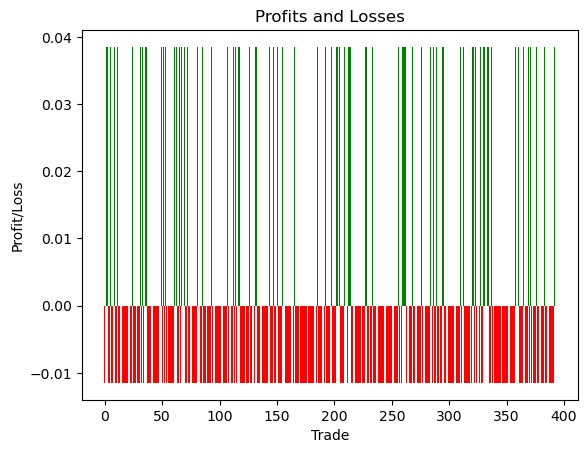

In [70]:
# Plot bar plot of profits and losses
profits = pd.DataFrame(trades)['Profit']

plt.bar(np.arange(len(profits)),profits, color=['g' if p>=0 else 'r' for p in profits])
# Add labels and title
plt.xlabel('Trade')
plt.ylabel('Profit/Loss')
plt.title('Profits and Losses')

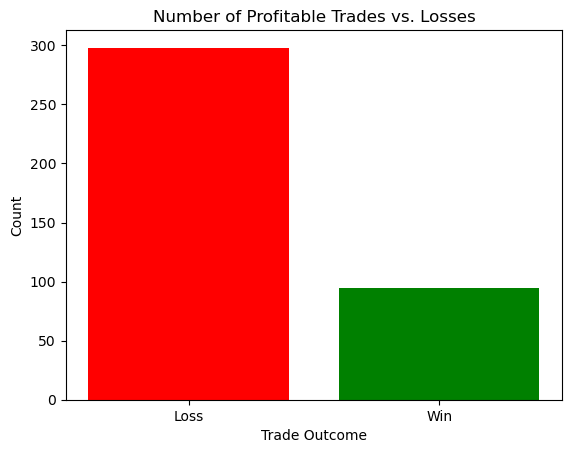

Win Rate: 24.17%


In [71]:
# Win rate
wins = sum(1 for profit in profits if profit > 0)
losses = sum(1 for profit in profits if profit < 0)

# Plot bar chart
plt.bar(['Loss', 'Win'], [losses,wins], color=['r','g'])
# Add labels and title
plt.xlabel('Trade Outcome')
plt.ylabel('Count')
plt.title('Number of Profitable Trades vs. Losses')

# Show the plot
plt.show()

# Display win rate
win_rate = wins / len(profits)
print(f"Win Rate: {win_rate:.2%}")

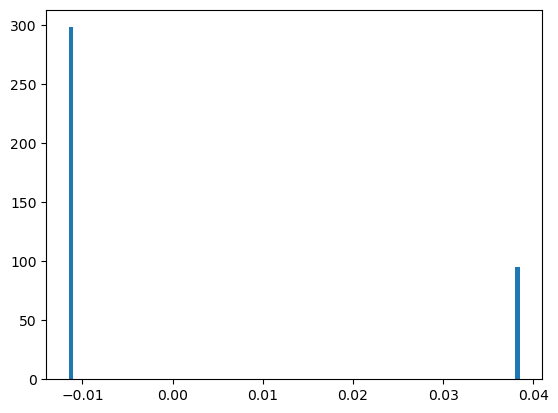

In [72]:
plt.hist(profits, bins=100)
plt.show()

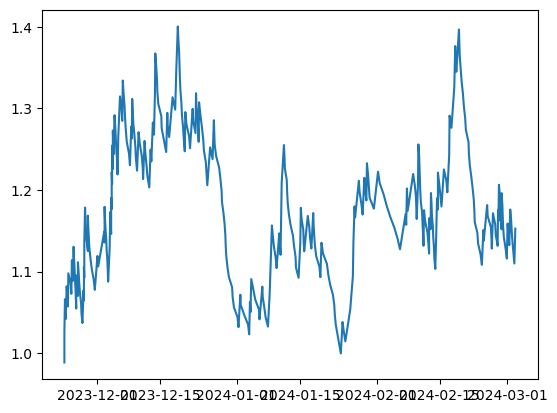

In [73]:
trades_df = pd.DataFrame(trades)

trades_df['cret'] = (trades_df['Profit'] + 1).cumprod()

plt.plot(trades_df['Exit Time'], trades_df['cret'])

#(pd.Series(profits) + 1).cumprod().plot()

In [74]:
import plotly.graph_objects as go
fig = go.Figure(data=go.Scatter(x=trades_df['Exit Time'], y=trades_df['cret'], mode='lines'))
fig.update_layout(title='Cumulative Profits', xaxis_title='Exit Time', yaxis_title='Cummulative Profits')

#TODO: Add buy and hold return series for comparison!

In [65]:
(pd.Series(profits) + 1).prod()

1.2599749881547544

In [66]:
# Calculate drawdowns
cumulative_profits = pd.Series(profits).cumsum()
cumulative_peak = cumulative_profits.cummax()
drawdowns = cumulative_peak - cumulative_profits

# Maximum drawdown
max_drawdown = drawdowns.max()

print(f"Maximum Drawdown: {max_drawdown}")

Maximum Drawdown: 0.25500000000000017


In [67]:
# Need to quantify the performance of every symbol on this strategy.
# Optimize the stop loss and take profit
# Fit ML models to try predict whether a trade will be successful or not (filter / position size management)
# Analyze the impact of having a trailing stop loss (trailing on/off)
# Dynamic stop loss or absolute